Importing libraries

In [ ]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib lmfit scikit-learn

In [ ]:
#calling up libraries
from datetime import datetime 
import pandas as pd
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from datetime import timedelta
from lmfit.models import LorentzianModel, Model, GaussianModel, SplitLorentzianModel, MoffatModel, VoigtModel, PseudoVoigtModel, Pearson7Model, StudentsTModel, LinearModel
import statistics
from matplotlib.collections import LineCollection 
import matplotlib as mpl
from sklearn.linear_model import LinearRegression

Importing data from google drive folder, sorting each into absorbance, spectroscope runs, and general spectroscope data.

In [ ]:
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/lab3/"
all_files = glob.glob(os.path.join(folder, '*.txt'))
Spec_data = {}
Sorb_data = {}
Irr_data = {}
titles = []



for filename in all_files:
  #Simplify name
  new_name = filename.replace(".txt", "").replace("/content/drive/MyDrive/lab3/","")
  #import data
  df = pd.read_csv(filename, sep='\t', header=12)
  df.reset_index(level=0, inplace =True)
  #and metadata
  time = pd.read_csv(filename, sep='\t', header=1, nrows=5)
  df.rec_time = pd.to_datetime(list(time)[0][5:]).time()
  df.int_time = float(time.iloc[3,0].replace("Integration Time (sec): ", ""))

  #Group data and set relevant metadata
  if ("Absorbance" in new_name) and ("smudge" not in new_name):
    df.columns = ['Wavelength(nm)', 'Absorbance']
    df.index = df['Wavelength(nm)']
    new_name = new_name.split("_", 1)[0]
    df.title = new_name + ' Absorbance'
    df.title2 = new_name
    Sorb_data[new_name +" "+ str(df.rec_time)] = df

  elif "Subt" in new_name and ("smudge" not in new_name): 
    df.columns = ['Wavelength(nm)', 'Counts']
    df.index = df['Wavelength(nm)']
    new_name = new_name.split("_", 1)[0]
    df.title = new_name + ' Spectrograph ' 
    df.title2 = new_name
    Spec_data[new_name +" "+ str(df.rec_time)] = df
    
  elif "HRD0" in new_name and ("smudge" not in new_name):
    df.columns = ['Wavelength(nm)', 'Counts']
    df.index = df['Wavelength(nm)']
    df['Flux'] = df['Counts']/df.int_time
    new_name = new_name.split("_", 1)[0]
    df.title = new_name + ' Energy Spectrum'
    df.title2 = new_name
    Irr_data[new_name +" "+ str(df.rec_time)] = df
  else:
    df.columns = ['Wavelength(nm)', '???']
    df.title = new_name + '???'
  #Put names for each test in a list
  titles.append(new_name)







Mounted at drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

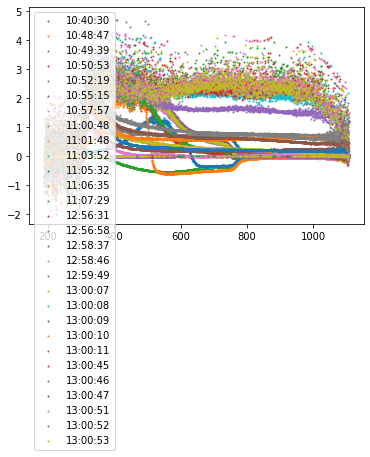

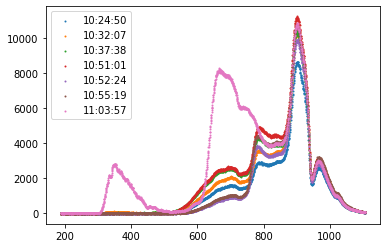

In [ ]:
for name in Sorb_data:
  new_name=name.split(" ")[1]
  if "MAPI" or "TC" in name:
    plt.scatter(Sorb_data[name].index, Sorb_data[name]['Absorbance'], s=1, label=new_name)
plt.legend()
plt.show()
for name in Irr_data:
  new_name=name.split(" ")[1]
  if "MAPI" or "TC" in name:
    plt.scatter(Irr_data[name].index, Irr_data[name]['Counts'], s=1, label=new_name)
plt.legend()
plt.show()

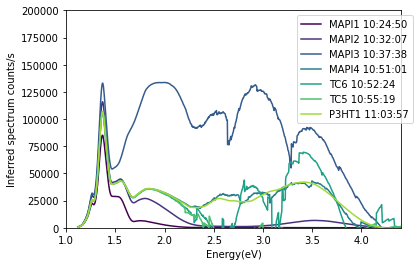

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


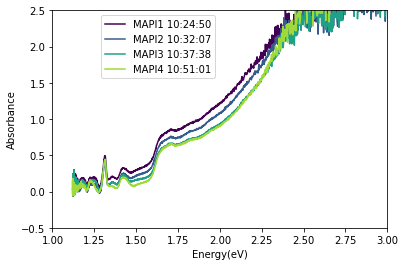

In [ ]:
from matplotlib import cm
from scipy.signal import savgol_filter
viridis = cm.get_cmap('viridis', 8)
MAPI_sorb = {}
i=0
hc = 1239.842
for name in Irr_data:
  irr_iq = Irr_data[name]
  che = name.split(" ", 1)[0]
  for s in Sorb_data:
    if che == s.split(" ",1)[0]:
      irr_iq['Absorbance'] = Sorb_data[s]['Absorbance']
      irr_iq['WLSpectrum'] = irr_iq['Flux']*(10**irr_iq['Absorbance'])
      plt.plot(hc/irr_iq['Wavelength(nm)'], savgol_filter(irr_iq['WLSpectrum'], 201, 3), label = name, color=viridis(i))
      i=i+1


plt.ylim(0,200000)
plt.xlim(1,4.4)
plt.ylabel('Inferred spectrum counts/s')
plt.xlabel('Energy(eV)')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()
i=0
for name in Irr_data:
  if name[0:4] == 'MAPI':
    irr_iq = Irr_data[name]
    irr_iq['Reference'] = savgol_filter(Irr_data['MAPI3 10:37:38']['Counts']*(10**Irr_data['MAPI3 10:37:38']['Absorbance']), 201, 3)
    irr_iq['Absorbance'] = -np.log10(irr_iq['Counts']/irr_iq['Reference'])
    
    plt.plot(hc/irr_iq['Wavelength(nm)'], irr_iq['Absorbance'], label = name, color=viridis(i))
    irr_iq['Energy(eV)'] = hc/irr_iq['Wavelength(nm)']
    MAPI_sorb[name] = irr_iq
  i=i+2
plt.ylim(-0.5,2.5)
plt.xlim(1,3)
plt.ylabel('Absorbance')
plt.xlabel('Energy(eV)')
plt.legend(bbox_to_anchor=(.5,1))
plt.show()

Plot: 
- absorbance
- attenuation coefficient (beer lambert -- alpha* l = ln(10)* A)
-  Tauc plot: (alpha*E)^2 vs E

For PL:
- Intensity
- Peak Wavelength
- Line Width
- Stability


In [ ]:
#get rid of p3ht data, focus on perovskites for report
for name in list(Sorb_data):
  Sorb_data[name] = Sorb_data[name][Sorb_data[name].index > 350]
  if name[0:4] == 'P3HT':
    del Sorb_data[name]

  

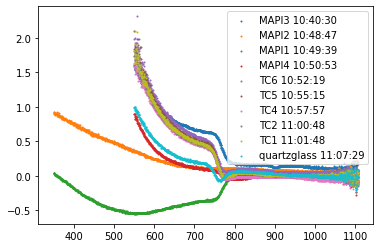

KeyError: ignored

In [ ]:
for name in Sorb_data:
  bads = []
  df = Sorb_data[name]
  for i in range(len(df.index)):
    if np.std(df['Absorbance'][i:(i+10)]) > 0.2:
      bads.append(df.index[i])
  if len(bads) > 10:
    Sorb_data[name] = df[df.index >= 550]
  plt.scatter(np.asarray(Sorb_data[name].index), np.asarray(Sorb_data[name]['Absorbance']), s=1, label=name)
plt.legend()
plt.show()
Sorb_data['quartzglass 11:07:29'] = Sorb_data['quartzglass 11:07:29'].set_index('Energy(eV)')
Sorb_data['quartzglass 11:07:29'] = Sorb_data['quartzglass 11:07:29'].sort_index()
print(Sorb_data['quartzglass 11:07:29'])
plt.scatter(np.asarray(Sorb_data['quartzglass 11:07:29'].index), np.asarray(Sorb_data['quartzglass 11:07:29']['Absorbance']), s=1, label='quartzglass 11:07:29')
plt.show


In [ ]:
#Add in energies and separate out data sets w/baseline

TC_sorb = {}
for name in sorted(Sorb_data):
  Sorb_data[name]['Energy(eV)']  = 1239.84198/Sorb_data[name]['Wavelength(nm)']

  if name[0:2] == 'TC':
    TC_sorb[name] = Sorb_data[name]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


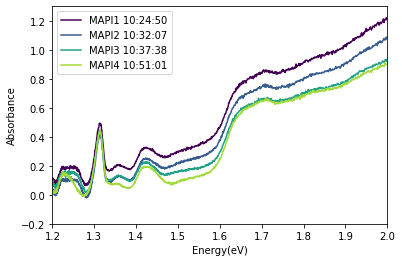

In [ ]:
i=0
for name in MAPI_sorb:
  if name[0:2] == 'qu':
    plt.plot(np.asarray(MAPI_sorb[name]['Energy(eV)']), np.asarray(MAPI_sorb[name]['Absorbance']), 'b--', dashes=(5,15), label = name)
  elif "smudge2" not in name:
    plt.plot(np.asarray(MAPI_sorb[name]['Energy(eV)']), np.asarray(MAPI_sorb[name]['Absorbance']), label=name, color=viridis(i))
  i=i+2
plt.legend()
plt.xlim(1.2,2.0)
plt.ylim(-0.2,1.3)
plt.xlabel('Energy(eV)')
plt.ylabel('Absorbance')
plt.show()

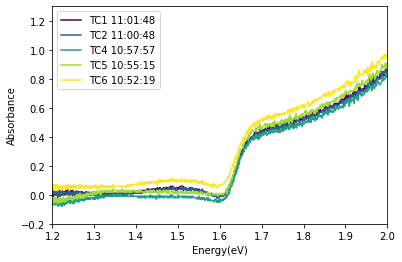

In [ ]:
i=0
for name in TC_sorb:
  if name[0:2] == 'qu':
    plt.plot(np.asarray(TC_sorb[name]['Energy(eV)']), np.asarray(TC_sorb[name]['Absorbance']), 'b--', dashes=(5,15), label=name)
  else:
    plt.plot(np.asarray(TC_sorb[name]['Energy(eV)']), np.asarray(TC_sorb[name]['Absorbance']), label=name, color=viridis(i))
  i=i+2
plt.legend()
plt.ylim(-0.2,1.3)
plt.xlim(1.2,2.0)
plt.xlabel('Energy(eV)')
plt.ylabel('Absorbance')  
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


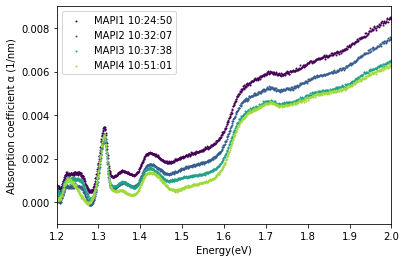

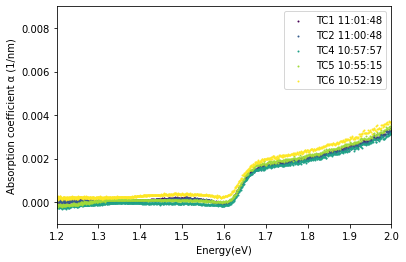

In [ ]:
for name in MAPI_sorb:
  MAPI_sorb[name] = MAPI_sorb[name][MAPI_sorb[name]['Wavelength(nm)']>550]

#adding in tauc plot of data set
def alpha(data, f_thick):
  data['alpha'] = (data['Absorbance']*np.log(10)/f_thick)
i=0
for name in MAPI_sorb:
  alpha(MAPI_sorb[name], 330)
  if name[0:2] == 'qu':
    plt.plot(np.asarray(MAPI_sorb[name]['Energy(eV)']), np.asarray(MAPI_sorb[name]['alpha']), 'b--', dashes=(5,15), label=name)
  else:
    plt.scatter(np.asarray(MAPI_sorb[name]['Energy(eV)']), np.asarray(MAPI_sorb[name]['alpha']), label=name, color=viridis(i), s=1)
  i=i+2
plt.xlabel('Energy(eV)')
plt.ylabel('Absorption coefficient α (1/nm)') 
plt.xlim(1.2,2.0)
plt.ylim(-0.001,0.009)
plt.legend()
plt.show()
i=0
for name in TC_sorb:
  alpha(TC_sorb[name], 600)
  if name[0:2] == 'qu':
    plt.plot(np.asarray(TC_sorb[name]['Energy(eV)']), np.asarray(TC_sorb[name]['alpha']), 'b--', dashes=(5,15), label=name)
  else:
    plt.scatter(np.asarray(TC_sorb[name]['Energy(eV)']), np.asarray(TC_sorb[name]['alpha']), label=name, color=viridis(i), s=1)
  i=i+2
plt.xlabel('Energy(eV)')
plt.ylabel('Absorption coefficient α (1/nm)') 
plt.xlim(1.2,2.0)
plt.ylim(-0.001,0.009)
plt.legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

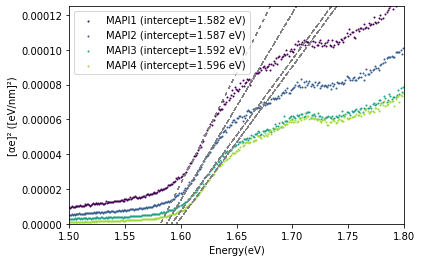

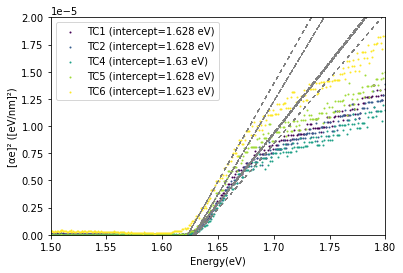

In [ ]:
#adding in tauc plot of data set
i=0
TC_Eg=[]
MAPI_Eg=[]
def tauc_plot(data, f_thick):
  data['Tauc value'] = (data['Absorbance']*data['Energy(eV)']*np.log(10)/f_thick)**2
for name in MAPI_sorb:
  tauc_plot(MAPI_sorb[name], 330)
  if name[0:2] == 'qu':
    plt.plot(np.asarray(MAPI_sorb[name]['Energy(eV)']), np.asarray(MAPI_sorb[name]['Tauc value']), 'b--', dashes=(5,15), label=name)
    
  extrap = MAPI_sorb[name][MAPI_sorb[name]['Energy(eV)'].between(1.61, 1.63)]
  #https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
  X = extrap.loc[:, 'Energy(eV)'].values.reshape(-1, 1)  # values converts it into a numpy array
  Y = extrap.loc[:, 'Tauc value'].values.reshape(-1, 1) 
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  reg = LinearRegression().fit(X,Y)
  Eg = float(np.around(-reg.intercept_/reg.coef_, 3))
  plt.scatter(np.asarray(MAPI_sorb[name]['Energy(eV)']), np.asarray(MAPI_sorb[name]['Tauc value']), label=name.split(sep=' ')[0]+' (intercept='+str(Eg)+' eV)', color=viridis(i), s=1)
  Y_pred = linear_regressor.predict(MAPI_sorb[name][MAPI_sorb[name]['Energy(eV)'].between(1.58, 1.65)].values.reshape(-1, 1))  # make predictions
  plt.plot(MAPI_sorb[name][MAPI_sorb[name]['Energy(eV)'].between(1.58, 1.65)].values.reshape(-1, 1), Y_pred, linestyle= (0,(5,10)), linewidth=0.5, color='gray')
  i=i+2
  MAPI_Eg.append(float(-reg.intercept_/reg.coef_))
plt.xlim(1.5, 1.8)
plt.ylim(0,0.000125)
plt.xlabel('Energy(eV)')
plt.ylabel('[αe]² ([eV/nm]²)') 
plt.legend()
plt.show()
for name in TC_sorb:
  tauc_plot(TC_sorb[name], 600)

plt.xlabel('Energy(eV)')
plt.ylabel('[αe]² ([eV/nm]²)') 
plt.xlim(1.5, 1.8)
plt.ylim(0,0.00002)
i=0
for name in TC_sorb:
  extrap = TC_sorb[name][TC_sorb[name]['Energy(eV)'].between(1.63, 1.65)]
  #https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
  X = extrap.loc[:, 'Energy(eV)'].values.reshape(-1, 1)  # values converts it into a numpy array
  Y = extrap.loc[:, 'Tauc value'].values.reshape(-1, 1) 
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  reg = LinearRegression().fit(X,Y)
  Eg = float(np.around(-reg.intercept_/reg.coef_, 3))
  plt.scatter(np.asarray(TC_sorb[name]['Energy(eV)']), np.asarray(TC_sorb[name]['Tauc value']), label=name.split(sep=' ')[0]+' (intercept='+str(Eg)+' eV)', color=viridis(i), s=1)
  Y_pred = linear_regressor.predict(TC_sorb[name][TC_sorb[name]['Energy(eV)'].between(1.58, 1.65)].values.reshape(-1, 1))  # make predictions
  plt.plot(TC_sorb[name][TC_sorb[name]['Energy(eV)'].between(1.58, 1.65)].values.reshape(-1, 1), Y_pred, linestyle= (0,(5,10)), linewidth=0.5, color='gray')
  i=i+2
  TC_Eg.append(float(-reg.intercept_/reg.coef_))
plt.legend()
plt.show()

In [ ]:
M1=np.mean(TC_Eg)
S1=np.std(TC_Eg)
M2=np.mean(MAPI_Eg)
S2=np.std(MAPI_Eg)
print(str(M1)+ " +/- "+str(S1))
print(str(M2)+ " +/- "+str(S2))

1.6274713288924976 +/- 0.0024558755635296194
1.589292808732547 +/- 0.005293356011765977


-

590.007


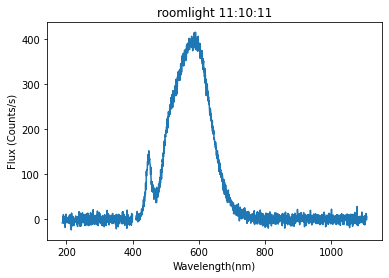

769.289


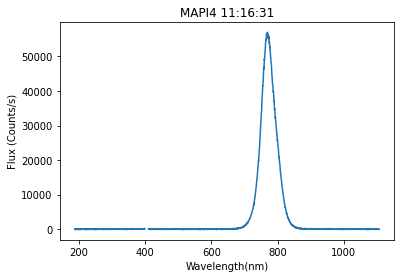

769.7310000000001


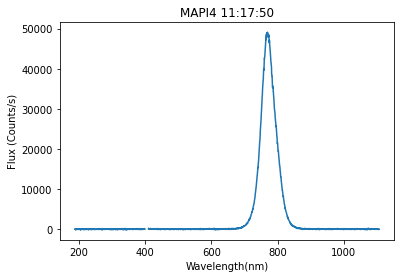

769.289


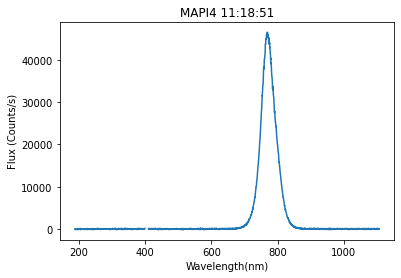

769.7310000000001


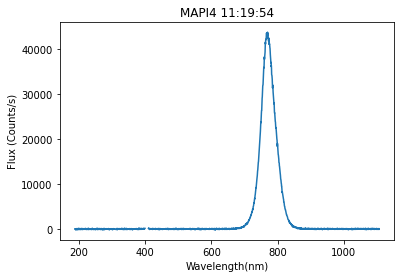

769.289


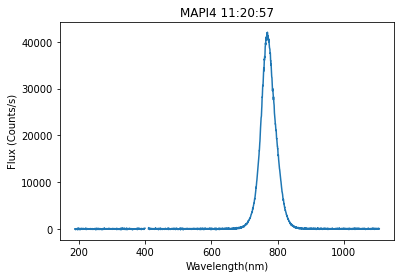

770.613


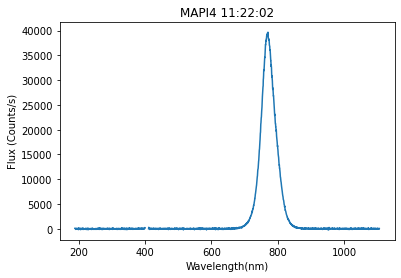

769.289


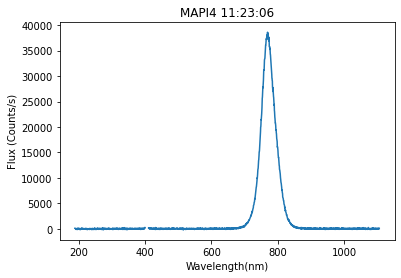

769.289


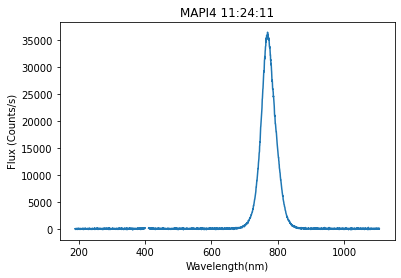

769.289


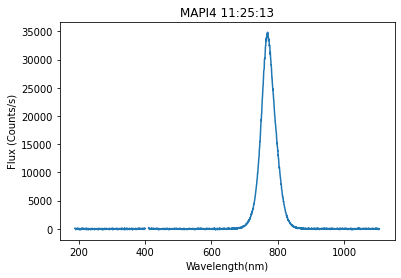

769.7310000000001


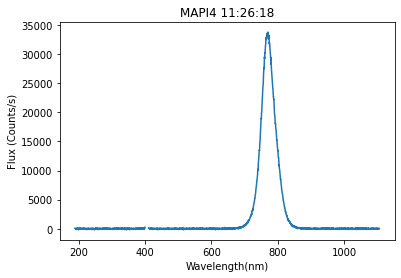

770.613


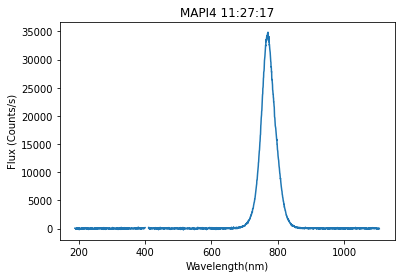

769.289


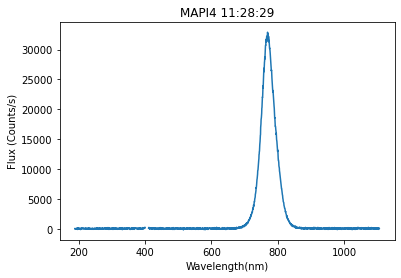

770.613


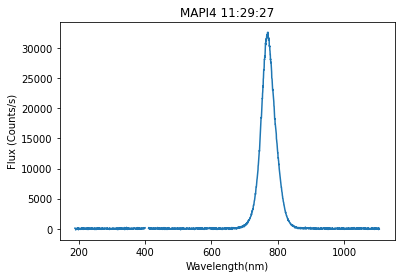

770.613


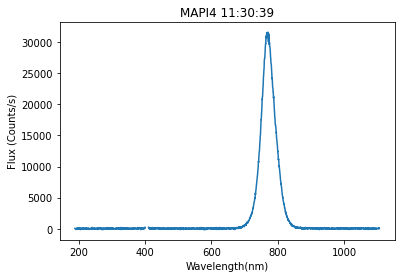

769.289


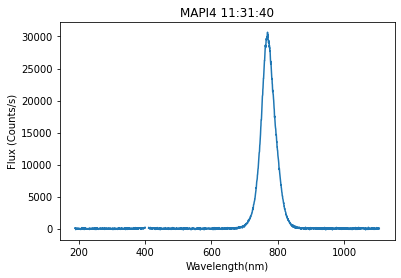

770.613


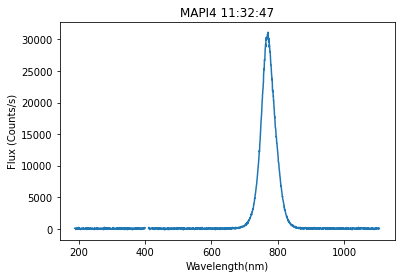

769.289


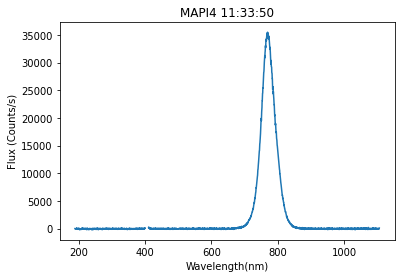

769.7310000000001


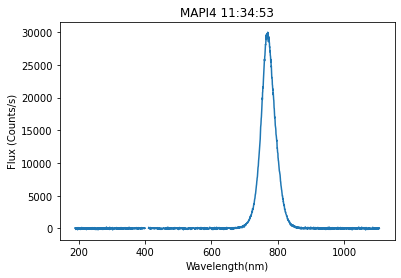

769.7310000000001


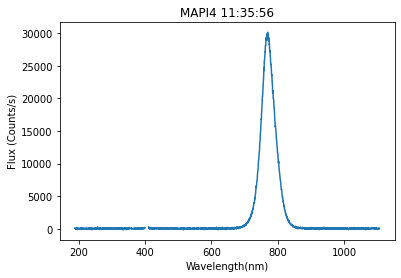

769.289


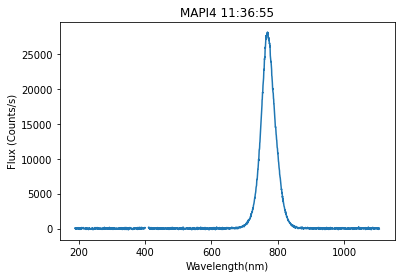

nan


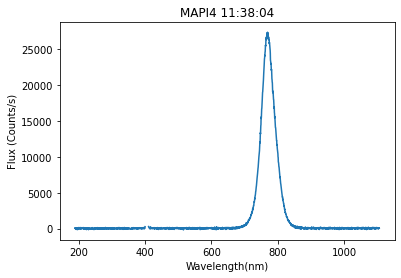

nan


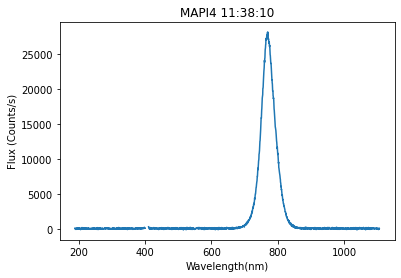

nan


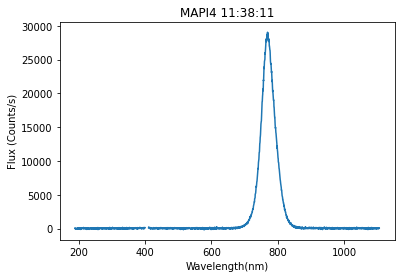

nan


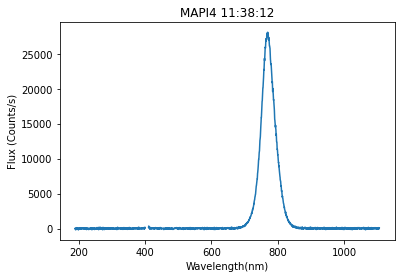

nan


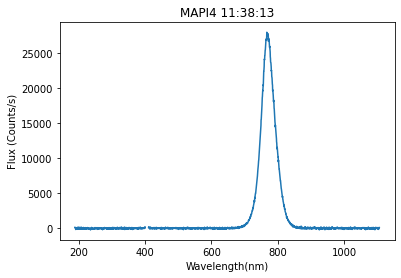

nan


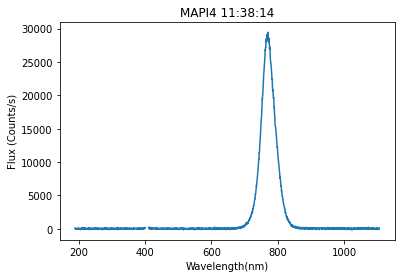

768.4069999999999


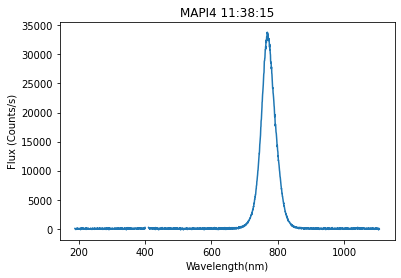

769.289


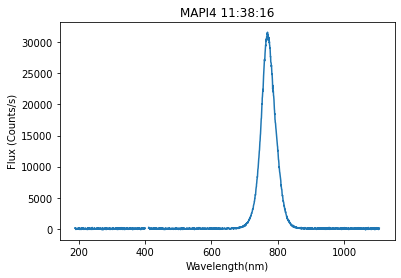

nan


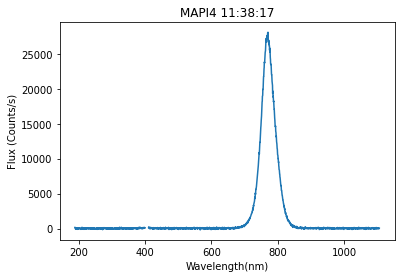

nan


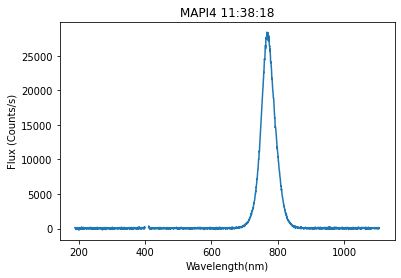

609.819


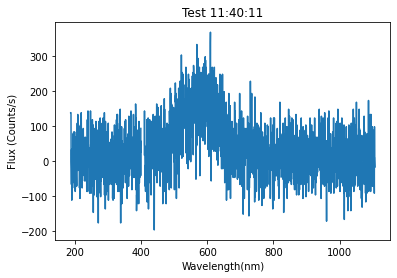

568.337


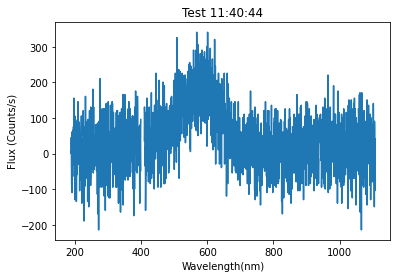

603.971


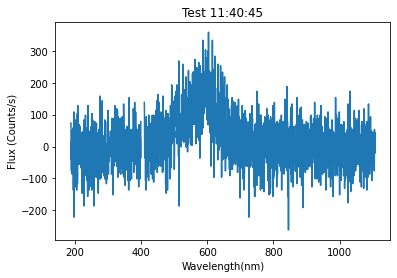

584.144


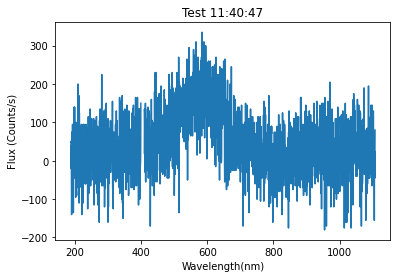

579.179


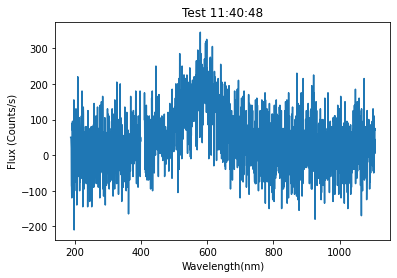

615.663


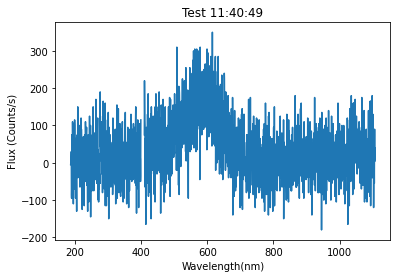

562.457


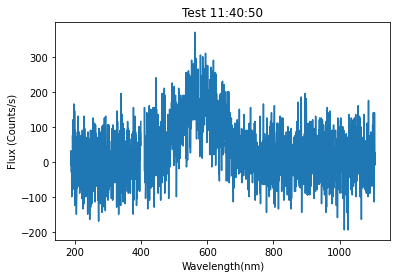

562.457


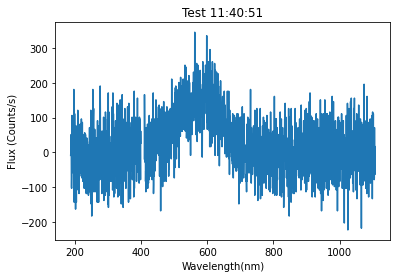

594.964


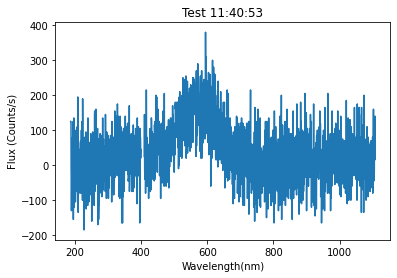

622.4019999999999


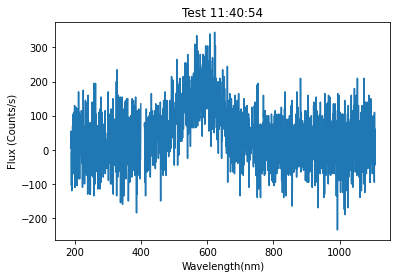

594.964


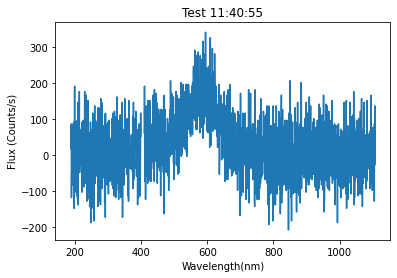

562.457


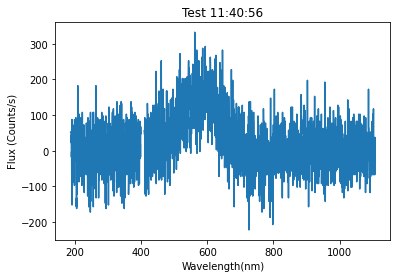

615.663


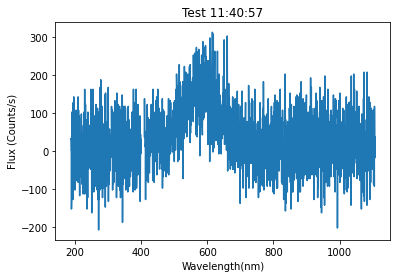

568.337


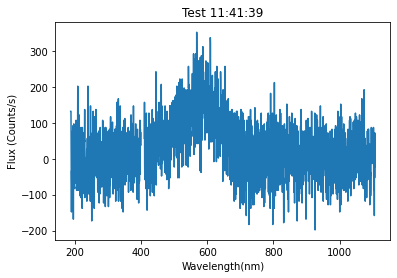

nan


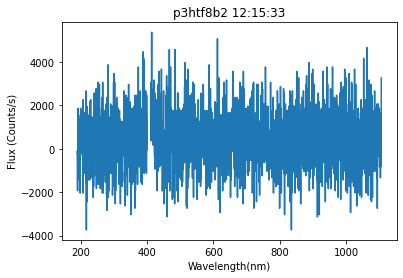

nan


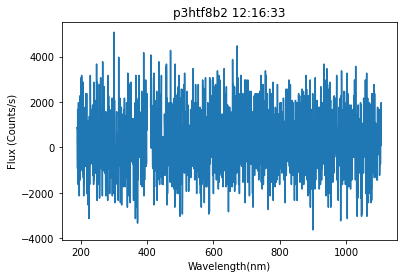

nan


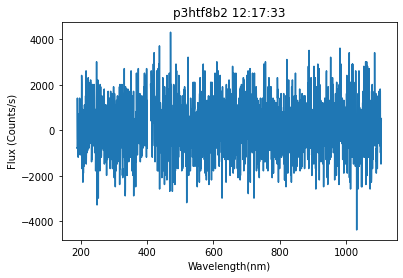

nan


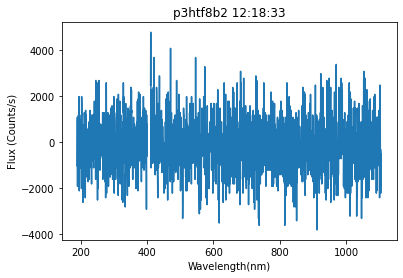

nan


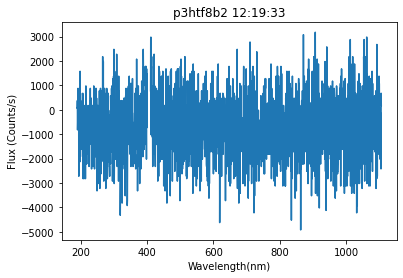

nan


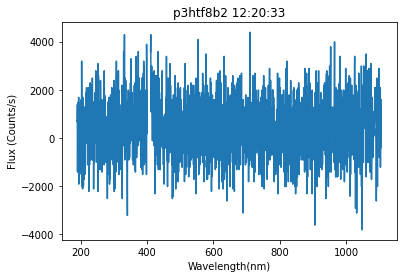

nan


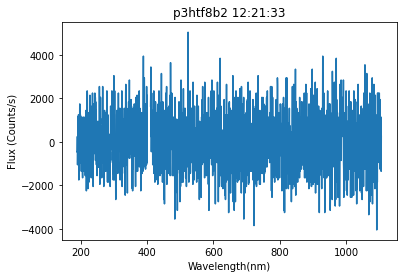

nan


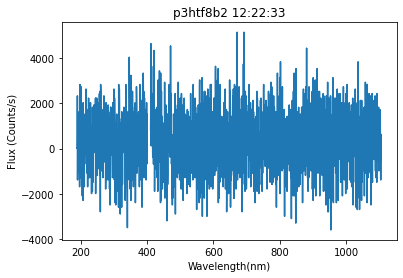

nan


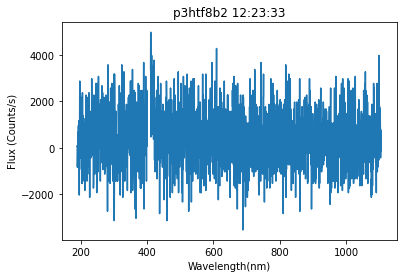

779.436


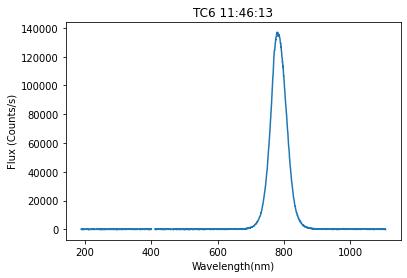

786.928


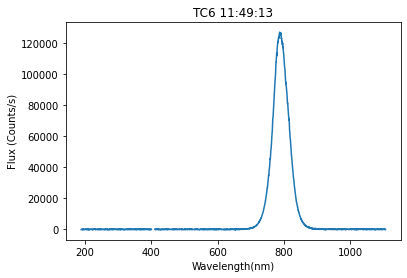

787.809


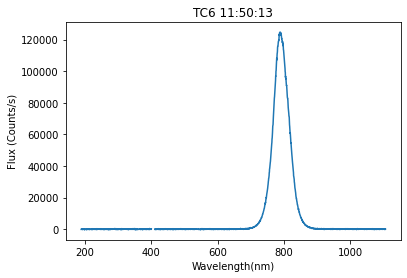

786.928


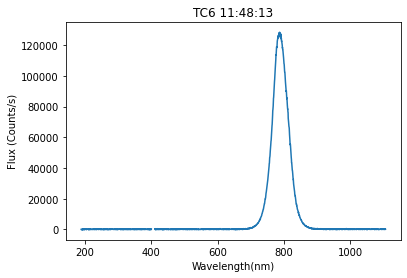

633.1709999999999


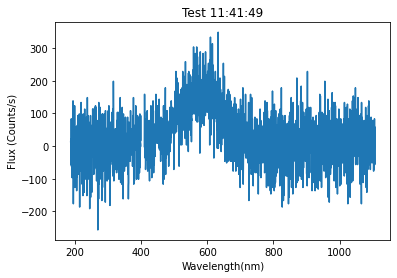

790.451


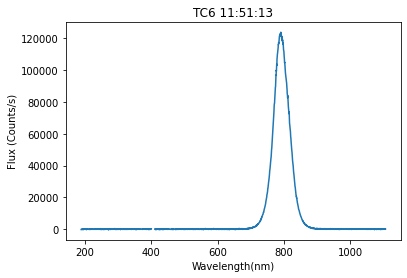

790.451


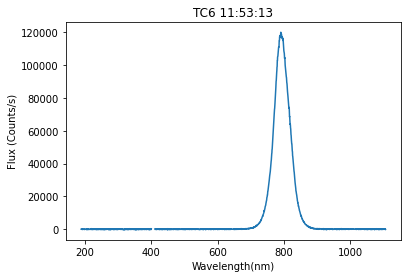

790.451


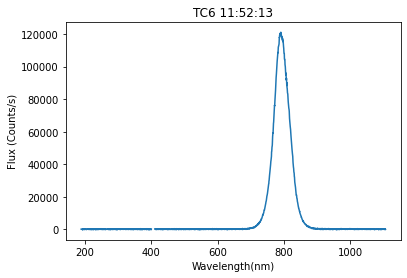

785.6060000000001


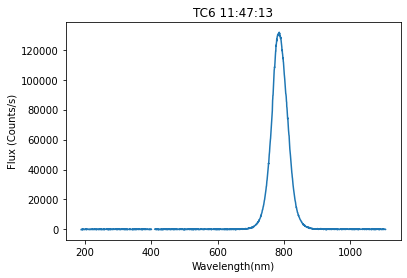

790.451


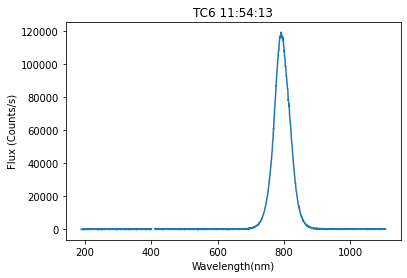

790.0110000000001


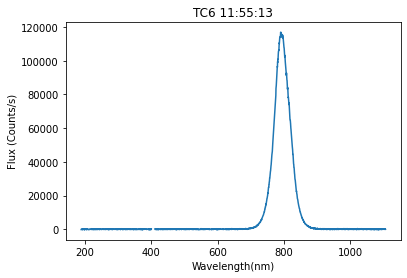

793.533


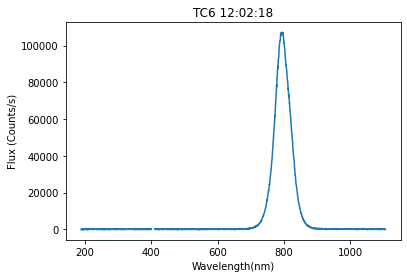

790.451


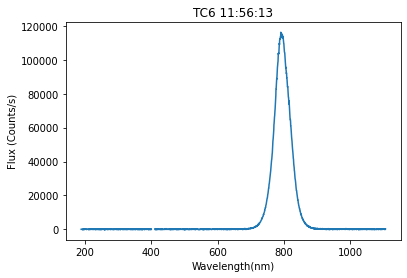

790.451


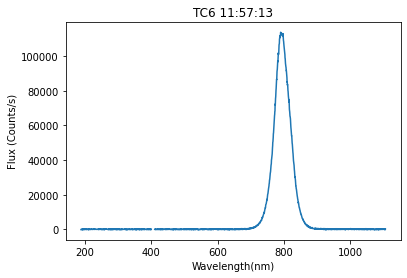

795.7339999999999


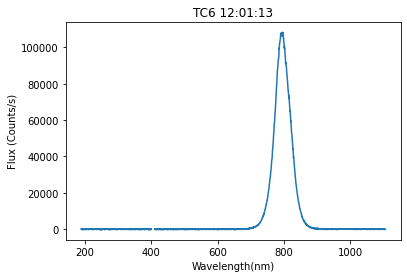

791.7719999999999


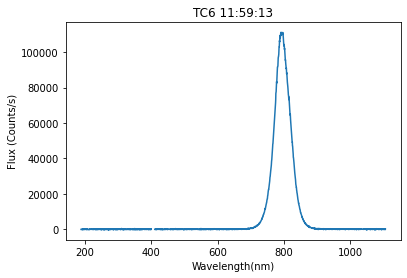

790.451


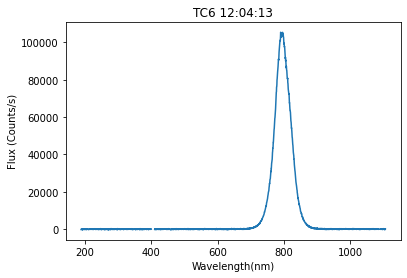

790.451


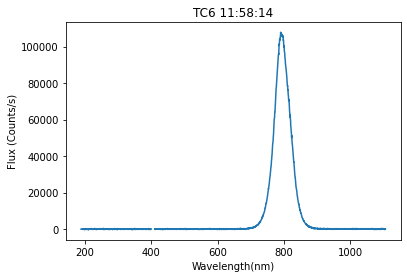

795.7339999999999


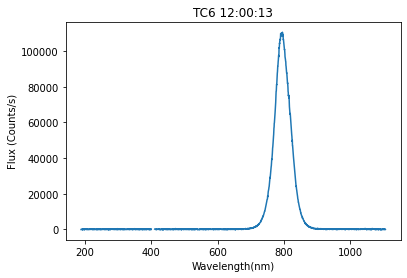

796.174


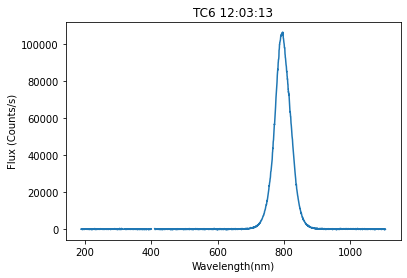

797.4939999999999


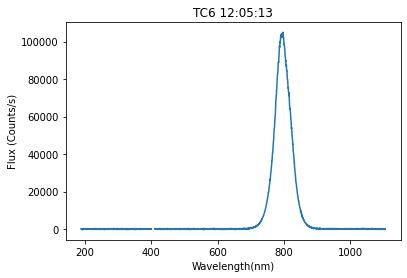

nan


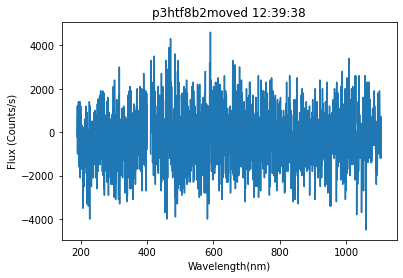

539.349


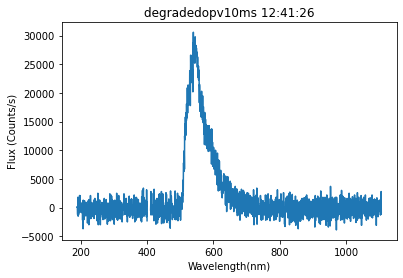

nan


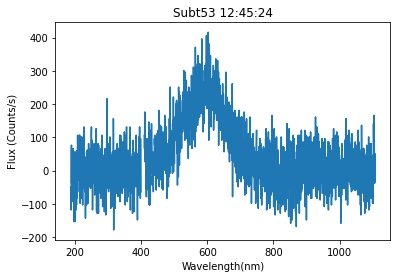

nan


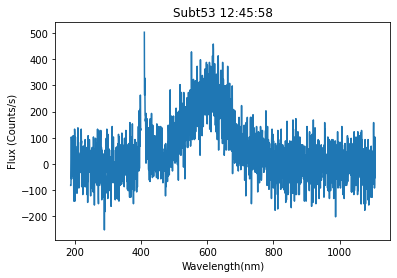

nan


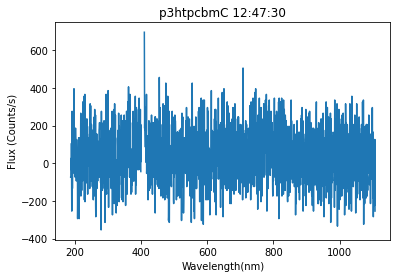

nan


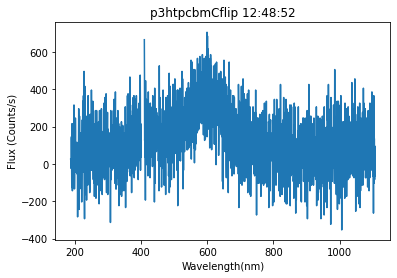

nan


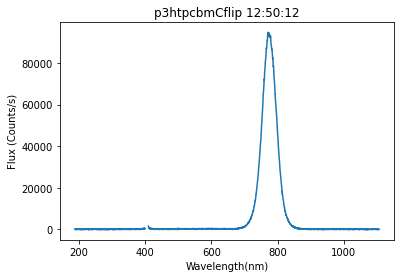

772.3789999999999


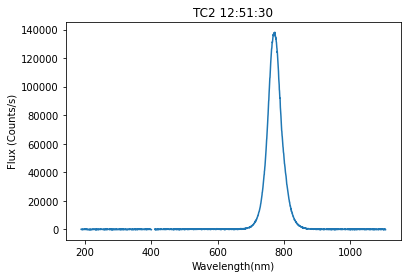

nan


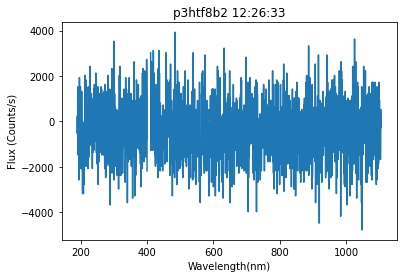

nan


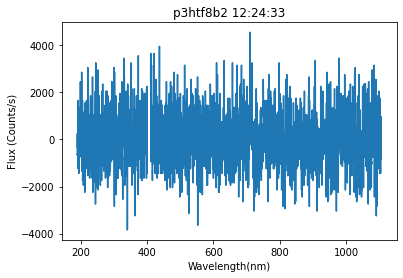

nan


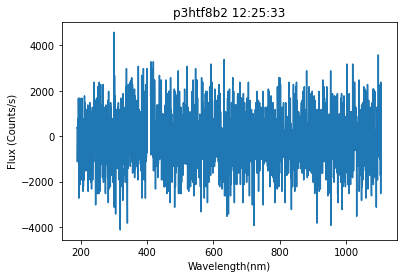

nan


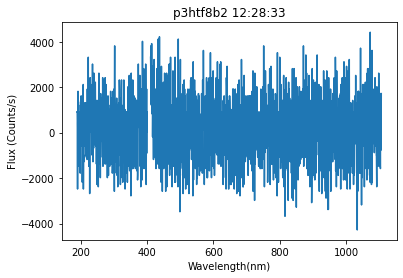

nan


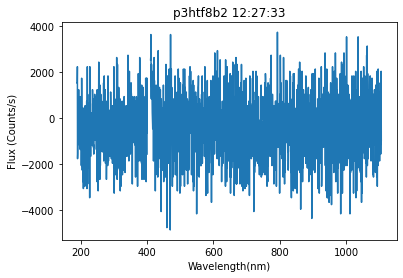

nan


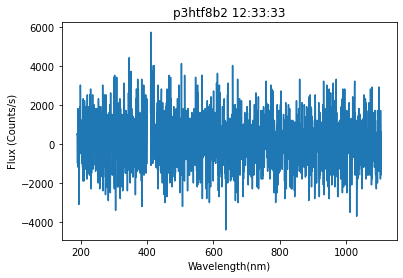

nan


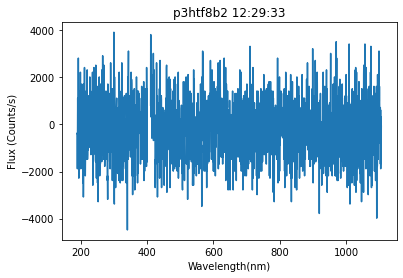

nan


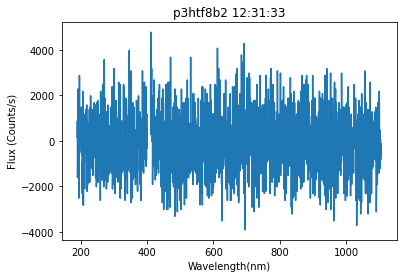

nan


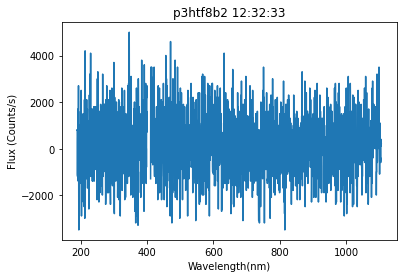

nan


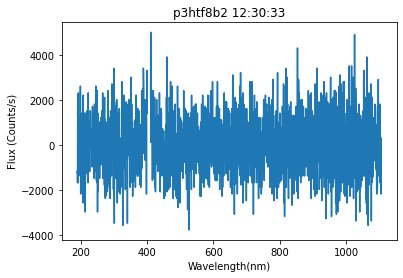

nan


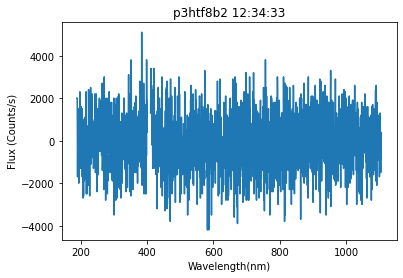

In [ ]:
for spec in Spec_data:
    fig, ax = plt.subplots()
    ax.set_xlabel('Wavelength(nm)')
    ax.set_ylabel('Flux (Counts/s)')
    ax.set_title(spec)
    Spec_data[spec]['Wavelength(nm)'] = Spec_data[spec]['Wavelength(nm)'][~(Spec_data[spec]['Wavelength(nm)'].between(400,410))]
    plt.plot(np.asarray(Spec_data[spec]['Wavelength(nm)']), np.asarray(Spec_data[spec]['Counts'])/Spec_data[spec].int_time)
    print(Spec_data[spec]['Counts'].idxmax())
    plt.show()

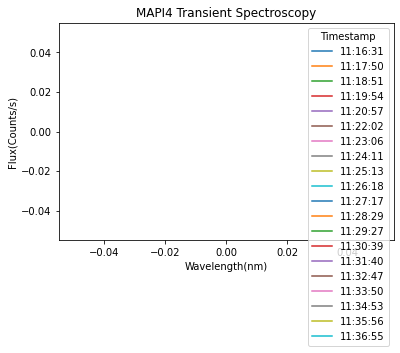

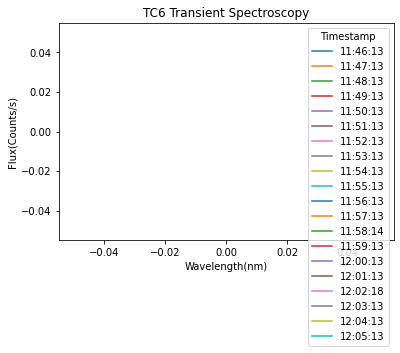

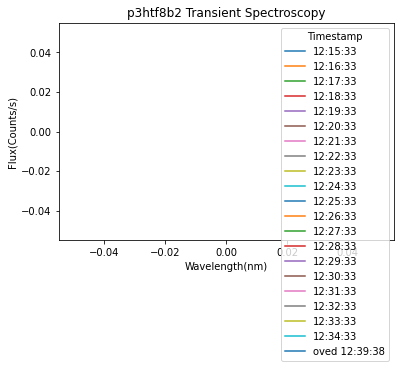

In [ ]:
def spec_laser_data(name):
  plt.subplots()
  for spec in sorted(Spec_data):
    if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:00' and name == 'MAPI4':
      plt.plot(np.asarray(Spec_data['MAPI4 11:16:31']['Wavelength(nm)'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)]), np.asarray(Spec_data[spec]['Counts'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)])/Spec_data[spec].int_time, label=spec[(len(name)+1):])
      plt.legend(title='Timestamp')
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Wavelength(nm)')
      plt.ylabel('Flux(Counts/s)')
    elif spec[:(len(name))] == name and name != 'MAPI4':
      plt.plot(np.asarray(Spec_data['MAPI4 11:16:31']['Wavelength(nm)'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)]), np.asarray(Spec_data[spec]['Counts'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)])/Spec_data[spec].int_time, label=spec[(len(name)+1):])
      plt.legend(title='Timestamp')
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Wavelength(nm)')
      plt.ylabel('Flux(Counts/s)')
spec_laser_data('MAPI4')
plt.show()
spec_laser_data('TC6')
plt.show()
spec_laser_data('p3htf8b2')
plt.show()


In [ ]:
for name in Spec_data:
  Spec_data[name]['Energy(eV)'] = hc/Spec_data[name]['Wavelength(nm)']

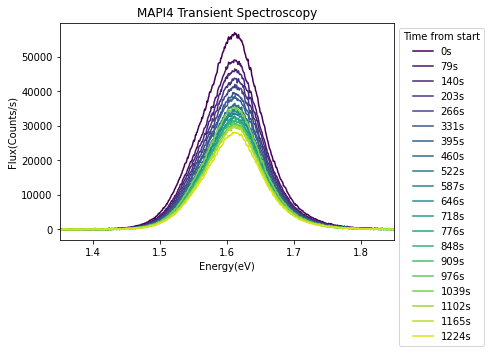

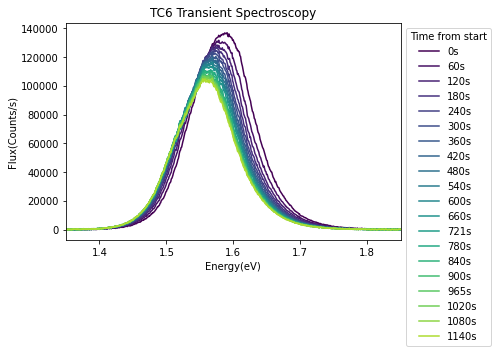

In [ ]:
colormap = cm.get_cmap('viridis')
prev_name = " "
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
c1='white' 
c2='black' 
n=20

def spec_time_data(name, prev_name = prev_name):
  plt.subplots()
  for spec in sorted(Spec_data):
    if spec[:(len(name))] != prev_name:
      firsttime = pd.to_datetime(spec.split(sep=" ")[1],format= '%H:%M:%S' )
    if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:00' and name == 'MAPI4':
      plt.plot(np.asarray(Spec_data[spec]['Energy(eV)']), np.asarray(Spec_data[spec]['Counts'])/Spec_data[spec].int_time, label=str(pd.Timedelta((pd.to_datetime(spec[(len(name)+1):],format= '%H:%M:%S' ) - firsttime)).seconds)+'s', color=colormap(pd.Timedelta((pd.to_datetime(spec[(len(name)+1):],format= '%H:%M:%S' ) - firsttime)).seconds/1300))
      plt.legend(title='Time from start',  bbox_to_anchor=(1,1), loc="upper left")
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Energy(eV)')
      plt.ylabel('Flux(Counts/s)')
    elif spec[:(len(name))] == name and name != 'MAPI4':
      plt.plot(np.asarray(Spec_data[spec]['Energy(eV)']), np.asarray(Spec_data[spec]['Counts'])/Spec_data[spec].int_time, label=str(pd.Timedelta((pd.to_datetime(spec[(len(name)+1):],format= '%H:%M:%S' ) - firsttime)).seconds)+'s', color=colormap(pd.Timedelta((pd.to_datetime(spec[(len(name)+1):],format= '%H:%M:%S' ) - firsttime)).seconds/1300))
      plt.legend(title='Time from start',  bbox_to_anchor=(1,1), loc="upper left")
      plt.title(name + " Transient Spectroscopy")   
      plt.xlabel('Energy(eV)')
      plt.ylabel('Flux(Counts/s)')
    prev_name = spec[:(len(name))]
    plt.xlim(1.35,1.85)
spec_time_data('MAPI4')
plt.show()
spec_time_data('TC6')
plt.show()





  

In [ ]:
#let's clean this up, yeah?
Spec_data
mapi_data = {}
tc_data = {}
for name in sorted(Spec_data):
  if 'MAPI4' in name:
    firsttime = pd.to_datetime('11:16:31', format='%H:%M:%S')
    secs = pd.Timedelta((pd.to_datetime(name.split(sep=' ')[1],format= '%H:%M:%S' ) - firsttime)).seconds
    mapi_data[name+" t=" +str(secs)] = Spec_data[name][Spec_data[name]["Wavelength(nm)"].between(650,900)]
  elif 'TC6' in name:
    firsttime = pd.to_datetime('11:46:13', format='%H:%M:%S')
    secs = pd.Timedelta((pd.to_datetime(name.split(sep=' ')[1],format= '%H:%M:%S' ) - firsttime)).seconds
    tc_data[name+" t=" +str(secs)] = Spec_data[name][Spec_data[name]["Wavelength(nm)"].between(650,900)]
mapi_data

{'MAPI4 11:16:31 t=0':                 Wavelength(nm)  Counts  Energy(eV)
 Wavelength(nm)                                    
 650.194                650.194   25.19    1.906880
 650.642                650.642   24.19    1.905567
 651.089                651.089   36.19    1.904259
 651.537                651.537   21.19    1.902949
 651.984                651.984   22.19    1.901645
 ...                        ...     ...         ...
 898.172                898.172   -4.81    1.380406
 898.607                898.607    5.19    1.379738
 899.043                899.043   17.19    1.379069
 899.478                899.478   37.19    1.378402
 899.913                899.913   -8.81    1.377735
 
 [567 rows x 3 columns],
 'MAPI4 11:17:50 t=79':                 Wavelength(nm)  Counts  Energy(eV)
 Wavelength(nm)                                    
 650.194                650.194   17.94    1.906880
 650.642                650.642    7.94    1.905567
 651.089                651.089   33.94    1

{'a': -0.49623419961491994, 'b': 248.2104846391754, 'c': 769.8350797594488}


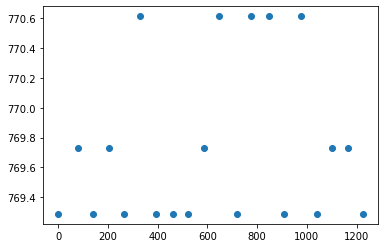

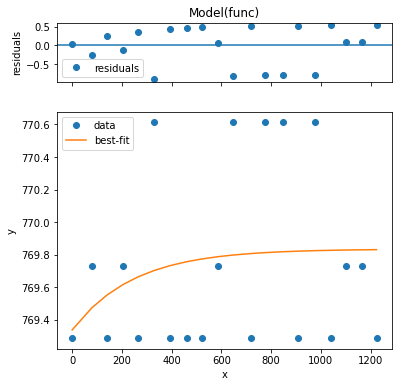

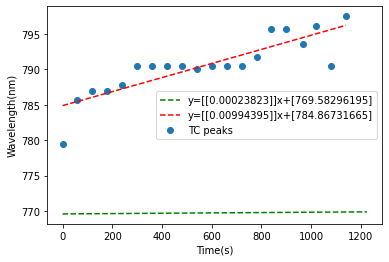

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
{'a': -13.145398082025197, 'b': 450.79353056679713, 'c': 795.4431435095722}


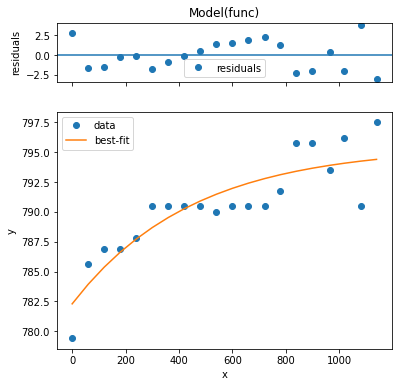

In [ ]:
#okay, let's clean this and do statistics!
times=[]
dexes=[]
maxes=[]
for name in mapi_data:
  time = int(name.split(sep="=")[1])
  times.append(time)
  dex = mapi_data[name]['Counts'].idxmax(axis=0)
  dexes.append(dex)
  max = mapi_data[name]['Counts'].max()
  maxes.append(max)

xtime = np.asarray(times[0:20])
ydex = np.asarray(dexes[0:20])
mapimax = np.asarray(maxes[0:20])
mapidf = pd.DataFrame(mapimax, index=xtime, columns=['Counts'])
df = pd.DataFrame(ydex, index=xtime, columns=['Wavelength(nm)'])
X = df.index.values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.loc[:, 'Wavelength(nm)'].values.reshape(-1, 1)
plt.scatter(X, Y, label = "MAPI peaks")
model = Model(func, independent_vars=['x'])
result = model.fit(Y, x=X, a=5000, b=337, c=5000)
print(result.values)
result.plot()
plt.show()
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
reg = LinearRegression().fit(X,Y)

Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, 'g--', label='y='+str(reg.coef_)+'x+'+str(reg.intercept_))

#Copy/paste for TC
times=[]
dexes=[]
maxes=[]
for name in tc_data:
  time = int(name.split(sep="=")[1])
  times.append(time)
  dex = tc_data[name]['Counts'].idxmax(axis=0)
  dexes.append(dex)
  max = tc_data[name]['Counts'].max()
  maxes.append(max)

xtime = np.asarray(times)
ydex = np.asarray(dexes)
tcmax = np.asarray(maxes[0:20])
tcdf = pd.DataFrame(tcmax, index=xtime, columns=['Counts'])
df = pd.DataFrame(ydex, index=xtime, columns=['Wavelength(nm)'])
X = df.index.values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.loc[:, 'Wavelength(nm)'].values.reshape(-1, 1)
plt.scatter(X, Y, label = "TC peaks")
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
reg = LinearRegression().fit(X,Y)

Y_pred = np.exp(1.25904852*(10**(-5))*X+6.66552074)  # make predictions
plt.plot(X, Y_pred, 'r--', label='y='+str(reg.coef_)+'x+'+str(reg.intercept_))
plt.xlabel('Time(s)')
plt.ylabel('Wavelength(nm)')
plt.legend()
plt.show()
print(linear_regressor.fit(X,Y))
model = Model(func, independent_vars=['x'])
result = model.fit(Y, x=X, a=5000, b=337, c=5000)
print(result.values)
result.plot()
plt.show()

[   0.   79.  140.  203.  266.  331.  395.  460.  522.  587.  646.  718.
  776.  848.  909.  976. 1039. 1102. 1165. 1224.]
[11398.19  9820.94  9300.    8765.5   8402.5   7934.19  7722.62  7305.94
  6968.81  6749.12  6970.38  6578.31  6526.75  6319.5   6132.94  6228.38
  7097.5   5997.12  6035.12  5621.62]
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      5214     -inf      inf    230.1     True     None     None
b     337.5     -inf      inf    39.65     True     None     None
c      5960     -inf      inf    167.3     True     None     None
None


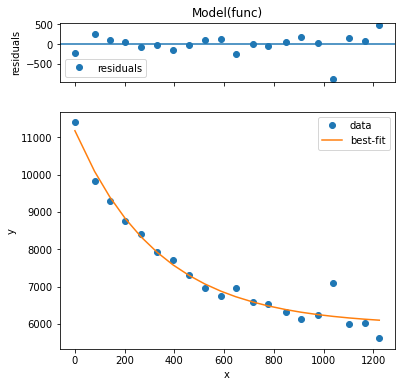

{'a': 4309.563847681745, 'b': 934.4713702891969, 'c': 9203.48743698992}


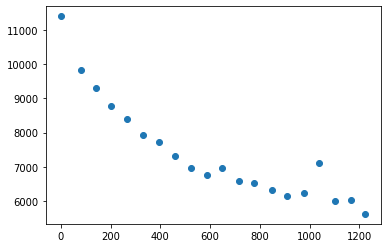

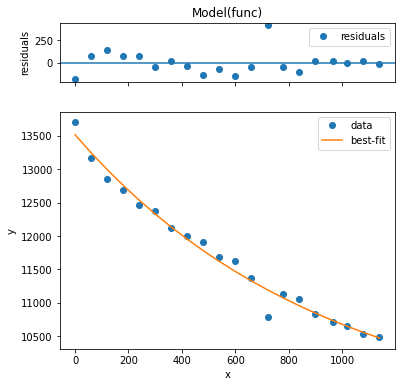

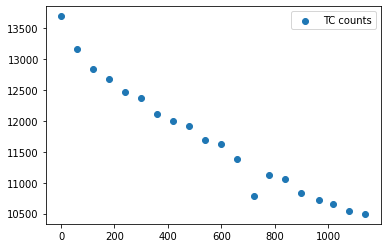

In [ ]:
#no more mr. linear regression!
#From documentation for scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy.optimize import curve_fit
def func(x, a, b, c):

    return a * np.exp(-x/b) + c

xdata = np.asarray(mapidf.index.astype(float))
ydata = np.asarray(mapidf['Counts'].astype(float))
print(xdata)
print(ydata)
from lmfit import Model, Parameter, report_fit
model = Model(func, independent_vars=['x'])
result = model.fit(ydata, x=xdata, a=5000, b=337, c=5000)
print(result.params.pretty_print())
result.plot()
plt.show()
plt.scatter(xdata, ydata, label='MAPI counts')
xdata = np.asarray(tcdf.index)
ydata = np.asarray(tcdf['Counts'])
model = Model(func, independent_vars=['x'])
result = model.fit(ydata, x=xdata, a=5000, b=337, c=5000)
print(result.values)
result.plot()
plt.show()
plt.scatter(xdata, ydata, label='TC counts')
plt.legend()
plt.show()

In [ ]:
MAPI_Spec = {}
TC_Spec ={}
for name in sorted(Spec_data):
  Spec_data[name]['Energy(eV)'] = hc/Spec_data[name]['Wavelength(nm)']
  Spec_data[name].index = Spec_data[name]['Energy(eV)']
  if "MAPI" in name:
    MAPI_Spec[name] =Spec_data[name]
  if 'TC' in name:
    TC_Spec[name] = Spec_data[name]
MAPI_Spec


{'MAPI4 11:16:31':             Wavelength(nm)  Counts  Energy(eV)
 Energy(eV)                                    
 6.597431           187.928   19.19    6.597431
 6.580728           188.405   19.19    6.580728
 6.564109           188.882   19.19    6.564109
 6.547574           189.359   -9.81    6.547574
 6.531156           189.835    2.19    6.531156
 ...                    ...     ...         ...
 1.122183          1104.848   18.19    1.122183
 1.121749          1105.276    1.19    1.121749
 1.121315          1105.704   17.19    1.121315
 1.120881          1106.132   14.19    1.120881
 1.120447          1106.560    2.19    1.120447
 
 [2048 rows x 3 columns],
 'MAPI4 11:17:50':             Wavelength(nm)  Counts  Energy(eV)
 Energy(eV)                                    
 6.597431           187.928    8.94    6.597431
 6.580728           188.405    8.94    6.580728
 6.564109           188.882    8.94    6.564109
 6.547574           189.359   -7.06    6.547574
 6.531156           189.

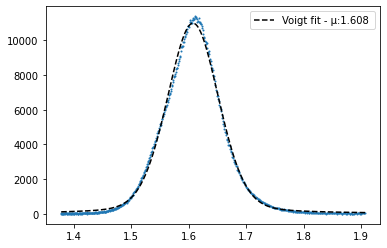

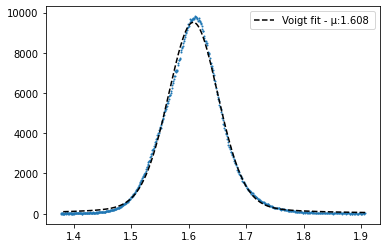

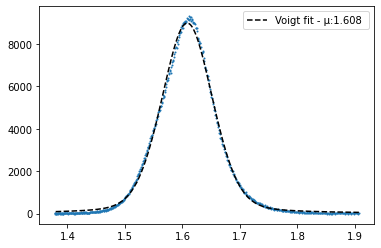

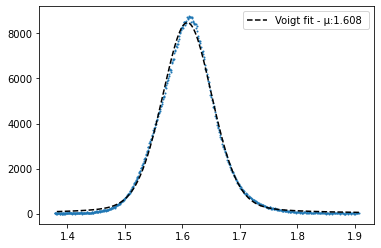

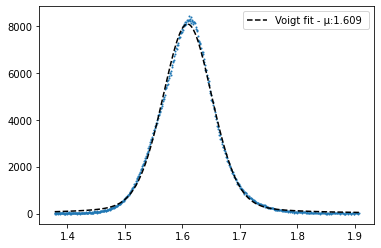

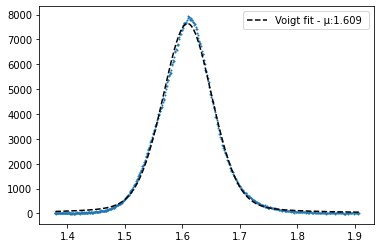

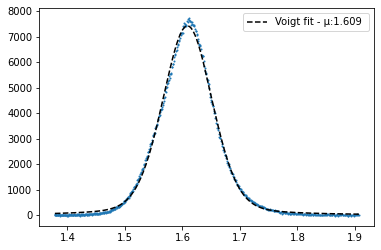

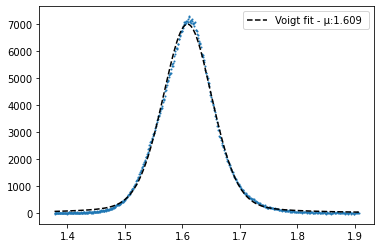

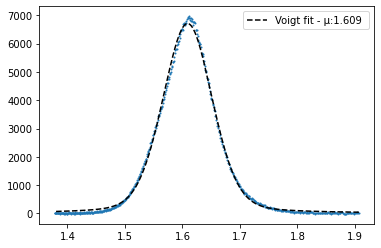

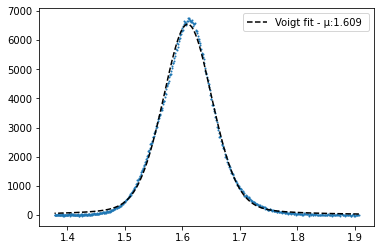

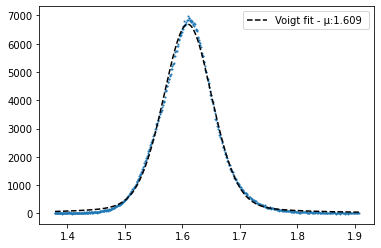

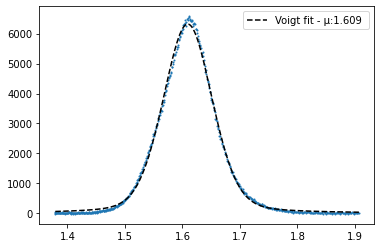

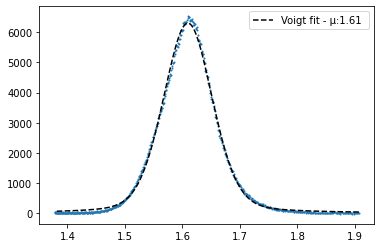

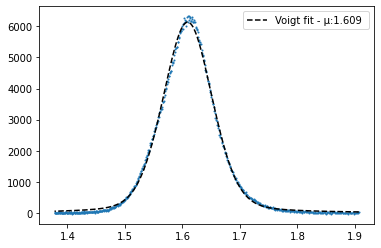

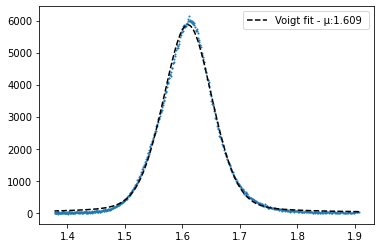

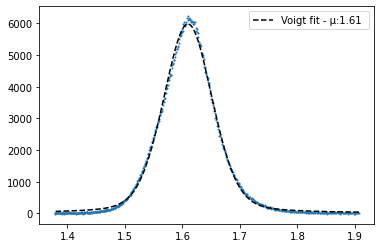

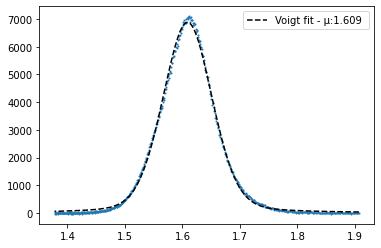

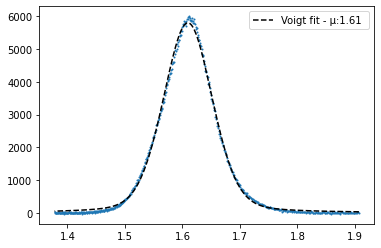

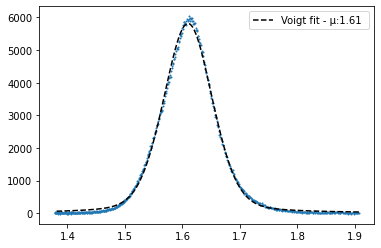

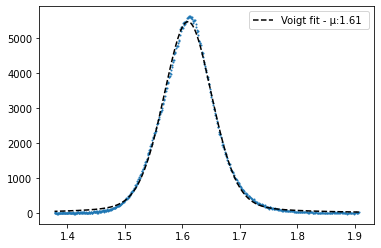

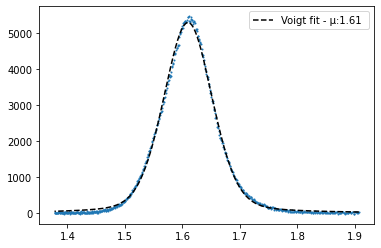

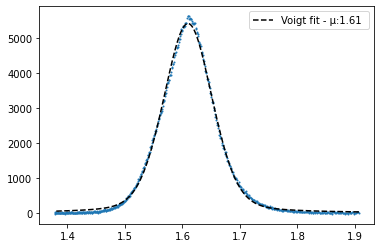

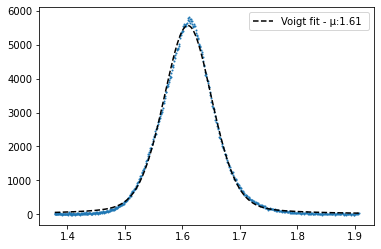

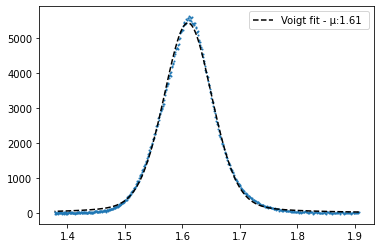

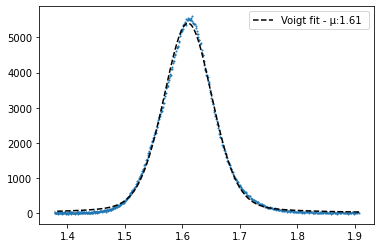

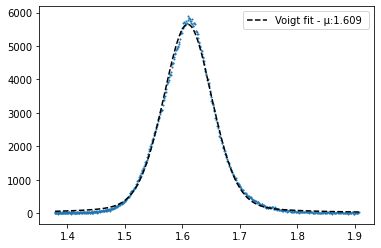

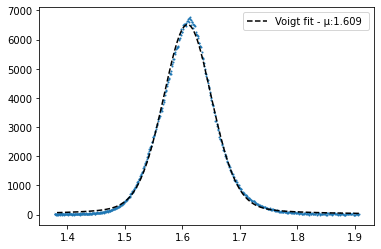

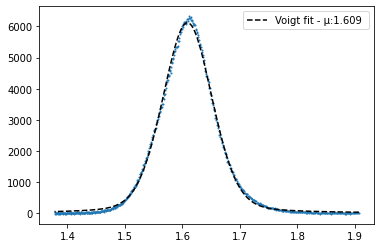

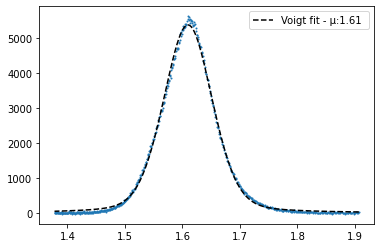

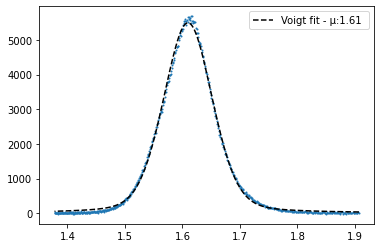

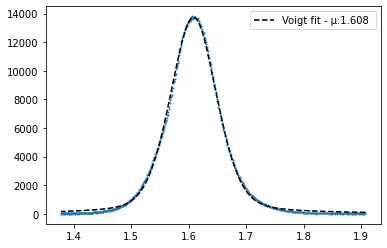

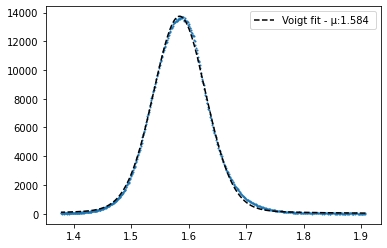

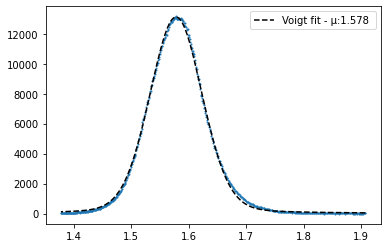

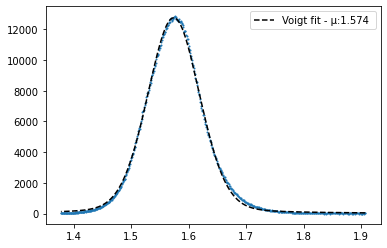

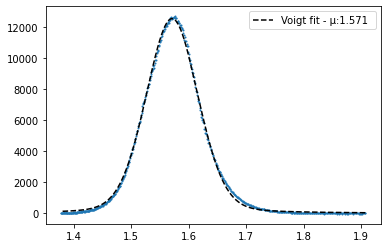

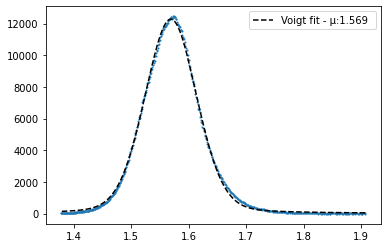

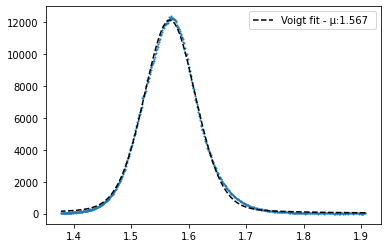

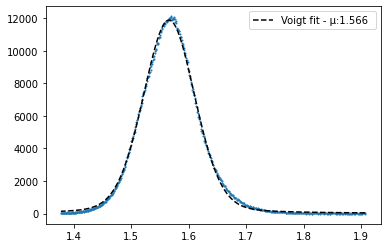

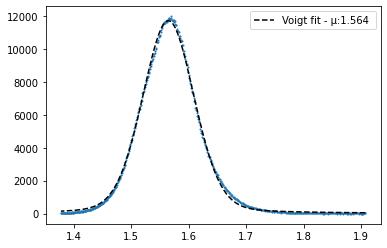

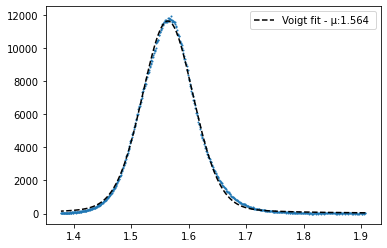

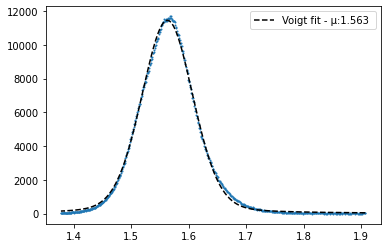

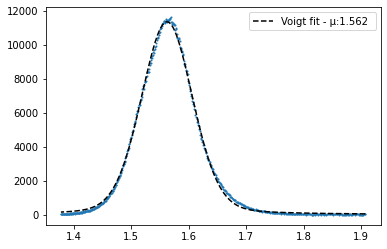

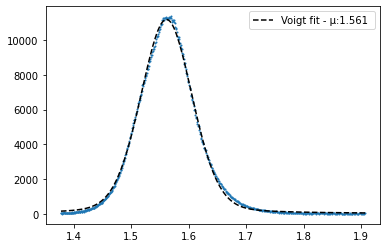

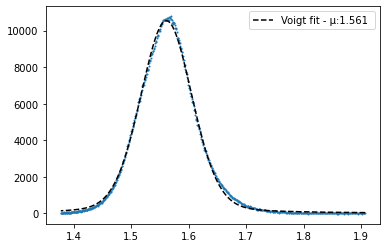

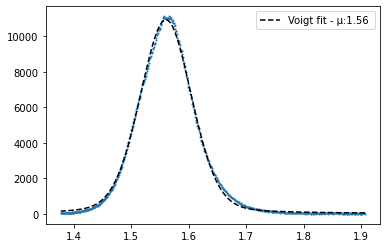

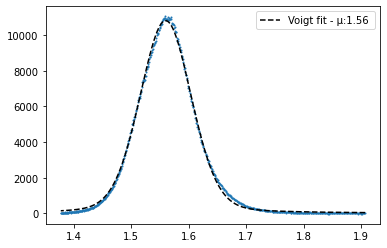

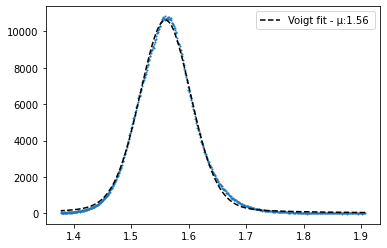

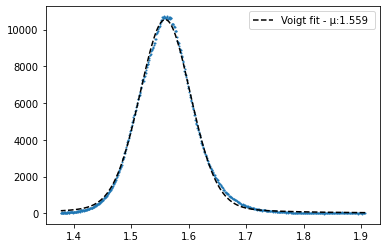

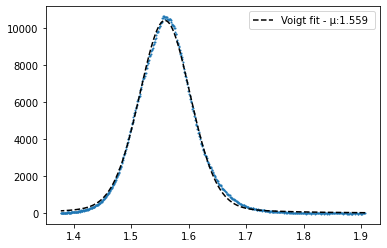

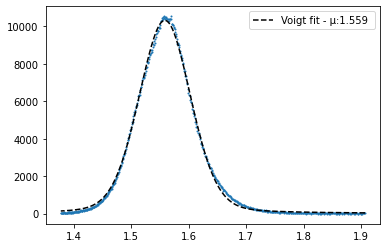

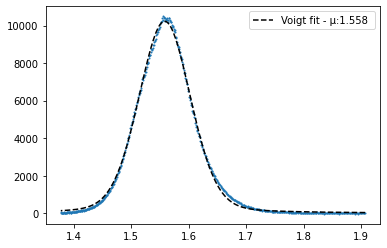

Alpha  Amplitude  Center  ...            Name   Type Timestamp
0   0.2624    1351.70  1.6075  ...  MAPI4 11:16:31  MAPI4  11:16:31
1   0.2744    1161.70  1.6080  ...  MAPI4 11:17:50  MAPI4  11:17:50
2   0.2787    1091.70  1.6083  ...  MAPI4 11:18:51  MAPI4  11:18:51
3   0.2853    1026.30  1.6085  ...  MAPI4 11:19:54  MAPI4  11:19:54
4   0.2901     973.12  1.6088  ...  MAPI4 11:20:57  MAPI4  11:20:57
5   0.2850     916.99  1.6089  ...  MAPI4 11:22:02  MAPI4  11:22:02
6   0.2916     890.21  1.6088  ...  MAPI4 11:23:06  MAPI4  11:23:06
7   0.2940     840.60  1.6088  ...  MAPI4 11:24:11  MAPI4  11:24:11
8   0.2880     799.18  1.6090  ...  MAPI4 11:25:13  MAPI4  11:25:13
9   0.2902     778.99  1.6091  ...  MAPI4 11:26:18  MAPI4  11:26:18
10  0.2932     794.17  1.6093  ...  MAPI4 11:27:17  MAPI4  11:27:17
11  0.2996     750.82  1.6092  ...  MAPI4 11:28:29  MAPI4  11:28:29
12  0.3003     747.13  1.6095  ...  MAPI4 11:29:27  MAPI4  11:29:27
13  0.2957     728.38  1.6091  ...  MAPI4 11:30:39  MAPI4  11:30:39
14  0.2900     693.25  1.6094  ...  MAPI4 11:31:40  MAPI4  11:31:40
15  0.3032     707.79  1.6096  ...  MAPI4 11:32:47  MAPI4  11:32:47
16  0.2688     809.74  1.6089  ...  MAPI4 11:33:50  MAPI4  11:33:50
17  0.2897     682.77  1.6095  ...  MAPI4 11:34:53  MAPI4  11:34:53
18  0.3031     685.86  1.6097  ...  MAPI4 11:35:56  MAPI4  11:35:56
19  0.2990     643.86  1.6096  ...  MAPI4 11:36:55  MAPI4  11:36:55
20  0.3085     625.02  1.6097  ...  MAPI4 11:38:04  MAPI4  11:38:04
21  0.3034     637.94  1.6097  ...  MAPI4 11:38:10  MAPI4  11:38:10
22  0.3100     657.50  1.6095  ...  MAPI4 11:38:11  MAPI4  11:38:11
23  0.2974     638.11  1.6096  ...  MAPI4 11:38:12  MAPI4  11:38:12
24  0.2947     636.09  1.6097  ...  MAPI4 11:38:13  MAPI4  11:38:13
25  0.2899     666.24  1.6092  ...  MAPI4 11:38:14  MAPI4  11:38:14
26  0.2857     768.59  1.6089  ...  MAPI4 11:38:15  MAPI4  11:38:15
27  0.2747     724.63  1.6088  ...  MAPI4 11:38:16  MAPI4  11:38:16
28  0.3023     633.28  1.6096  ...  MAPI4 11:38:17  MAPI4  11:38:17
29  0.2981     647.01  1.6096  ...  MAPI4 11:38:18  MAPI4  11:38:18
30  0.3626    1578.30  1.6083  ...    TC2 12:51:30    TC2  12:51:30
31  0.1616    1672.10  1.5840  ...    TC6 11:46:13    TC6  11:46:13
32  0.1890    1597.80  1.5779  ...    TC6 11:47:13    TC6  11:47:13
33  0.2011    1552.40  1.5738  ...    TC6 11:48:13    TC6  11:48:13
34  0.2063    1521.30  1.5709  ...    TC6 11:49:13    TC6  11:49:13
35  0.2148    1490.80  1.5688  ...    TC6 11:50:13    TC6  11:50:13
36  0.2241    1474.40  1.5671  ...    TC6 11:51:13    TC6  11:51:13
37  0.2207    1442.90  1.5657  ...    TC6 11:52:13    TC6  11:52:13
38  0.2230    1422.20  1.5645  ...    TC6 11:53:13    TC6  11:53:13
39  0.2257    1412.80  1.5636  ...    TC6 11:54:13    TC6  11:54:13
40  0.2304    1390.40  1.5628  ...    TC6 11:55:13    TC6  11:55:13
41  0.2355    1381.70  1.5621  ...    TC6 11:56:13    TC6  11:56:13
42  0.2295    1360.50  1.5614  ...    TC6 11:57:13    TC6  11:57:13
43  0.2347    1286.50  1.5612  ...    TC6 11:58:14    TC6  11:58:14
44  0.2338    1329.40  1.5604  ...    TC6 11:59:13    TC6  11:59:13
45  0.2326    1315.00  1.5600  ...    TC6 12:00:13    TC6  12:00:13
46  0.2296    1291.30  1.5595  ...    TC6 12:01:13    TC6  12:01:13
47  0.2361    1285.00  1.5592  ...    TC6 12:02:18    TC6  12:02:18
48  0.2296    1268.60  1.5588  ...    TC6 12:03:13    TC6  12:03:13
49  0.2314    1257.30  1.5586  ...    TC6 12:04:13    TC6  12:04:13
50  0.2327    1245.80  1.5583  ...    TC6 12:05:13    TC6  12:05:13

[51 rows x 8 columns]

In [ ]:

def beam_fit(data):
  #from https://stackoverflow.com/questions/49370795/lorentzian-module
  #from https://millenia.cars.aps.anl.gov/software/python/lmfit/examples/example_use_pandas.html
  x = np.asarray(data['Energy(eV)'])
  y= np.asarray(data['Counts'])
  data.reset_index(level=0, inplace =True, drop=True)
  model = PseudoVoigtModel()
  params = model.guess(data['Counts'], x=data['Energy(eV)'], cen=data['Counts'].idxmax(), amp=data['Counts'].max())
  result = model.fit(y, params, x=x)
  center = float(result.fit_report()[result.fit_report().find('center:')+12:result.fit_report().find('center:')+18])
  sigma = float(result.fit_report()[result.fit_report().find('sigma:')+12:result.fit_report().find('sigma:')+18])
  amplitude = float(result.fit_report()[result.fit_report().find('amplitude:')+12:result.fit_report().find('amplitude:')+18])
  height = float(result.fit_report()[result.fit_report().find('height:')+12:result.fit_report().find('height:')+18])
  alpha = float(result.fit_report()[result.fit_report().find('fraction:')+12:result.fit_report().find('fraction:')+18])
  plt.scatter(x, y, s=1)
  plt.plot(x, result.best_fit, 'k--', label='Voigt fit - μ:'+str(np.around(center,3))+' ')
  plt.legend(loc='best')
  plt.show()
  return {'Name':name,'Center':center, 'Linewidth':sigma, 'Amplitude':amplitude, 'Height':height, 'Alpha':alpha}
 
df = pd.DataFrame()
for name in MAPI_Spec:
    df = df.append(beam_fit(Spec_data[name][Spec_data[name]['Wavelength(nm)'].between(650,900)]), ignore_index=True)
for name in TC_Spec:
    df = df.append(beam_fit(Spec_data[name][Spec_data[name]['Wavelength(nm)'].between(650,900)]), ignore_index=True)

df['Type']= df['Name'].str.split(expand=True)[0]
df['Timestamp']= df['Name'].str.split(expand=True)[1]
df

In [ ]:
models = [PseudoVoigtModel(), VoigtModel(), LorentzianModel(), GaussianModel()]
mnames = ['PseudoVoigt', 'Voigt', 'Lorentzian', 'Gaussian']
def model_test(data, model, mname):
  x = np.asarray(data['Energy(eV)'])
  y= np.asarray(data['Counts'])
  data.reset_index(level=0, inplace =True, drop=True)
  params = model.guess(data['Counts'], x=data['Energy(eV)'], cen=data['Counts'].idxmax(), amp=data['Counts'].max())
  result = model.fit(y, params, x=x)
  center = float(result.fit_report()[result.fit_report().find('center:')+12:result.fit_report().find('center:')+18])
  sigma = float(result.fit_report()[result.fit_report().find('sigma:')+12:result.fit_report().find('sigma:')+18])
  amplitude = float(result.fit_report()[result.fit_report().find('amplitude:')+12:result.fit_report().find('amplitude:')+18])
  height = float(result.fit_report()[result.fit_report().find('height:')+12:result.fit_report().find('height:')+18])
  aic = result.aic
  plt.scatter(x, y, s=1)
  plt.plot(x, result.best_fit, '--', label=mname+' AIC: '+str(np.around(aic,3)), color=viridis(2*i))
  plt.xlabel('Energy(eV)')
  plt.ylabel('Flux(Counts/s)')
  plt.legend(loc='best')
  return aic
for name in Spec_data:
  testdata = Spec_data[name][Spec_data[name]['Wavelength(nm)'].between(650,900)]
  l = [0, 0, 0, 0]
  for i in range(4):
    l[i] = np.exp(-0.5*model_test(testdata, models[i], mnames[i]))
  plt.title(name)
  plt.show()
  l = l/sum(l)
  print(l)

In [ ]:
from scipy.optimize import curve_fit
from lmfit import Model, Parameter, report_fit
def func(x, a, b, c):

    return a * np.exp(-x/b) + c
def exp_fit(dataset, name, typ):
  xdata = np.asarray(dataset['T1'].astype(float))
  ydata = np.asarray(dataset[name].astype(float))
  model = Model(func, independent_vars=['x'])
  params = model.make_params(a=5000, b=337, c=5000)
  result = model.fit(ydata, params, x=xdata)
  a = result.values['a']
  b = result.values['b']
  c = result.values['c']
  if typ=='MAPI':
    col='blue'
    sty = ':'
  elif typ=='TC':
    col='orange'
    sty = '--'
  print(str(a)+' '+str(b)+' '+str(c))
  plt.scatter(xdata, ydata, s=20, label=typ)
  plt.plot(xdata, result.best_fit, sty, label=str(np.around(a,4))+'exp{-x/'+str(np.around(b,1))+'} + '+str(np.around(c,4)), color=col)
  plt.legend(loc='best')
  return result


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


     Alpha  Amplitude  Center   Height  ...            Name   Type Timestamp      T1
0   0.2624    1351.70  1.6075  10995.0  ...  MAPI4 11:16:31  MAPI4  11:16:31     0.0
1   0.2744    1161.70  1.6080   9518.3  ...  MAPI4 11:17:50  MAPI4  11:17:50    79.0
2   0.2787    1091.70  1.6083   8978.0  ...  MAPI4 11:18:51  MAPI4  11:18:51   140.0
3   0.2853    1026.30  1.6085   8481.6  ...  MAPI4 11:19:54  MAPI4  11:19:54   203.0
4   0.2901     973.12  1.6088   8071.8  ...  MAPI4 11:20:57  MAPI4  11:20:57   266.0
5   0.2850     916.99  1.6089   7639.3  ...  MAPI4 11:22:02  MAPI4  11:22:02   331.0
6   0.2916     890.21  1.6088   7423.1  ...  MAPI4 11:23:06  MAPI4  11:23:06   395.0
7   0.2940     840.60  1.6088   7013.3  ...  MAPI4 11:24:11  MAPI4  11:24:11   460.0
8   0.2880     799.18  1.6090   6710.2  ...  MAPI4 11:25:13  MAPI4  11:25:13   522.0
9   0.2902     778.99  1.6091   6543.9  ...  MAPI4 11:26:18  MAPI4  11:26:18   587.0
10  0.2932     794.17  1.6093   6688.6  ...  MAPI4 11:27:17  MAPI

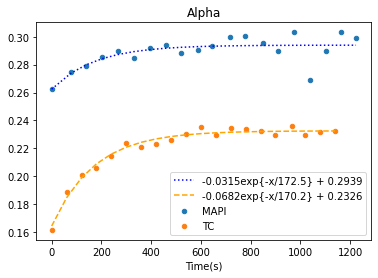

648.8725744796116 328.43338332825635 679.4110495532609
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a     648.9     -inf      inf    25.89     True     None     None
b     328.4     -inf      inf    34.36     True     None     None
c     679.4     -inf      inf    18.17     True     None     None
479.5496299640718 667.1792613291807 1167.3223567533983
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a     479.5     -inf      inf    28.07     True     None     None
b     667.2     -inf      inf    94.95     True     None     None
c      1167     -inf      inf    32.43     True     None     None


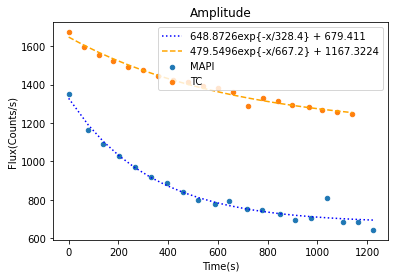

-0.0019139408796805583 346.6842652004594 1.6095131725144451
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a  -0.001914     -inf      inf 0.0001577     True     None     None
b     346.7     -inf      inf    77.18     True     None     None
c      1.61     -inf      inf 0.0001188     True     None     None
0.02439772383472414 287.5371289920784 1.5585536591421663
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a    0.0244     -inf      inf 0.0004413     True     None     None
b     287.5     -inf      inf    13.47     True     None     None
c     1.559     -inf      inf 0.0002948     True     None     None


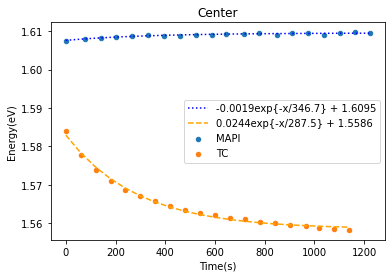

5045.251833477508 331.04652303083253 5765.993660843277
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      5045     -inf      inf    219.8     True     None     None
b       331     -inf      inf    37.98     True     None     None
c      5766     -inf      inf    155.8     True     None     None
4043.773307618696 705.7419740538032 9481.213513338977
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      4044     -inf      inf    270.6     True     None     None
b     705.7     -inf      inf    110.2     True     None     None
c      9481     -inf      inf    310.7     True     None     None


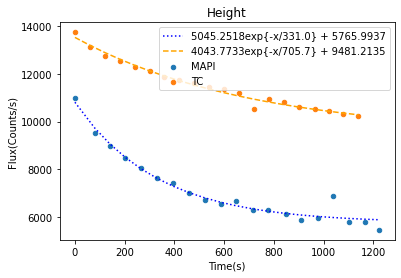

0.0027895342295024056 396.8102865038934 0.04995309383499053
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a   0.00279     -inf      inf 9.468e-05     True     None     None
b     396.8     -inf      inf    38.85     True     None     None
c   0.04995     -inf      inf 8.436e-05     True     None     None
0.001297835676554886 128.5773982376961 0.052840998158185326
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a  0.001298     -inf      inf 6.221e-05     True     None     None
b     128.6     -inf      inf     12.5     True     None     None
c   0.05284     -inf      inf 1.976e-05     True     None     None


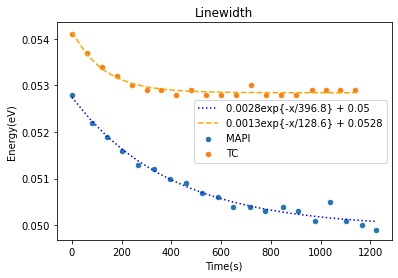

In [ ]:
df_M = df[df['Type'] == 'MAPI4']
df_M= df_M[df_M.index<20]
df_T = df[df['Type'] == 'TC6']
df_T['T1'] = (pd.to_datetime(df_T['Timestamp'],format= '%H:%M:%S') - pd.to_datetime('11:46:13', format='%H:%M:%S')).dt.total_seconds()
df_M['T1'] = (pd.to_datetime(df_M['Timestamp'],format= '%H:%M:%S') - pd.to_datetime('11:16:31', format='%H:%M:%S')).dt.total_seconds()
print(df_M)
for name in df_M.columns:
  if name not in ['Name', 'Type', 'Timestamp', 'T1']:
    plt.title(name)
    exp_fit(df_M, name, 'MAPI').params.pretty_print()
    exp_fit(df_T, name, 'TC').params.pretty_print()
    plt.xlabel('Time(s)')
    if name in ['Height', 'Amplitude']:
      plt.ylabel('Flux(Counts/s)')
    elif name in ['Linewidth', 'Center']:
      plt.ylabel('Energy(eV)')
    plt.legend()
    plt.show()


In [ ]:
df_M.Center.std()

0.0005683540408842336

In [ ]:
for data in laser_data:
  beam_fit(laser_data[data])
for data in Spec_data:
  transdata = Spec_data[data][Spec_data[data]['Wavelength(nm)'] > 450]
  beam_fit(transdata)
  transdata.center = Spec_data[data].center
  transdata.sigma = Spec_data[data].sigma
  transdata.amplitude = Spec_data[data].amplitude
  transdata.height = Spec_data[data].height


KeyError: ignored

In [ ]:
#time grouped data
spec_groups = {'MAPI4':[], 'TC6':[], 'p3htf8b2':[], 'roomlight':[], 'degraded':[], 'Subt53':[], 'p3htpcbm':[], 'MAPI4 short':[], 'TC2':[]}
for name in spec_groups:
  for spec in sorted(Spec_data):
    if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:05' and name == 'MAPI4':
      spec_groups[name].append(spec)
    elif spec[:(len(name))] == name and name == 'MAPI4':
      spec_groups['MAPI4 short'].append(spec)
    elif spec[:(len(name))] == name and name != 'MAPI4':
      spec_groups[name].append(spec)
  

In [ ]:
#Various transient bandwidth data

for name in spec_groups:
  heights = []
  centers = []
  sigmas = []
  times = []
  start_time = spec_groups[name][0].split()[1]
  for spec in spec_groups[name]:
    beam_fit(laser_data[spec])
    centers.append(laser_data[spec].center)
    heights.append(laser_data[spec].height)
    sigmas.append(laser_data[spec].sigma)
    times.append(float((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days ' + start_time))/timedelta(minutes = 1)))
  plt.subplot(2,2,1)
  plt.plot(times, heights)
  plt.xlabel('Time(min)')
  plt.ylabel('Height(counts)')
  plt.subplot(2,2,2)
  plt.plot(times, centers)
  plt.xlabel('Time(min)')
  plt.ylabel('Center(WL(nm))')
  plt.subplot(2,2,3)
  plt.plot(times, sigmas)
  plt.xlabel('Time(min)')
  plt.ylabel('Sigmas(WL(nm))')
  plt.suptitle(name + " Laser Beam Data")
  plt.show()
  print('Wavelength Average: ' + str(statistics.mean(centers)))


KeyError: ignored

In [ ]:
for name in spec_groups:
  heights = []
  centers = []
  sigmas = []
  times = []
  start_time = spec_groups[name][0].split()[1]
  for spec in spec_groups[name]:
    beam_fit(Spec_data[spec])
    centers.append(Spec_data[spec].center)
    heights.append(Spec_data[spec].height)
    sigmas.append(Spec_data[spec].sigma)
    times.append(float((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days ' + start_time))/timedelta(minutes = 1)))
  plt.subplot(2,2,1)
  plt.plot(times, heights)
  plt.xlabel('Time(min)')
  plt.ylabel('Height(counts)')
  plt.subplot(2,2,2)
  plt.plot(times, centers)
  plt.xlabel('Time(min)')
  plt.ylabel('Center(WL(nm))')
  plt.subplot(2,2,3)
  plt.plot(times, sigmas)
  plt.xlabel('Time(min)')
  plt.ylabel('Sigmas(WL(nm))')
  plt.suptitle(name + " Laser Beam Data")
  plt.show()
  print('Wavelength Average: ' + str(statistics.mean(centers)))

KeyError: ignored